In [10]:
import numpy as np
import matplotlib.pyplot as plt
from util.plot import plot_cdf,plot_lines,plot_box_by_config,plot_box,plot_grouped_boxplots,plot_scatter,plot_bars
from util.plot import color_list
import json
import os
from collections import defaultdict
import csv
import re

sys_name="m4"

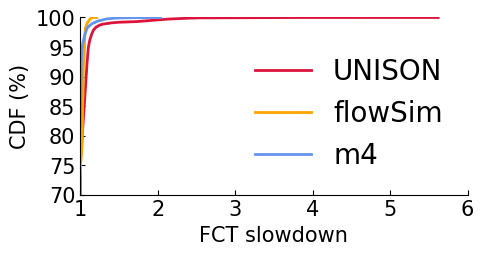

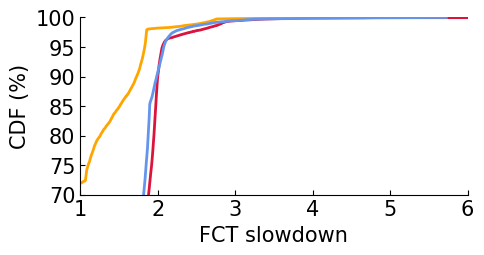

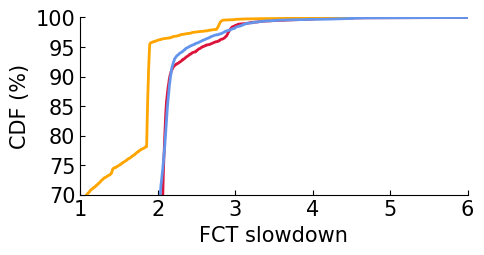

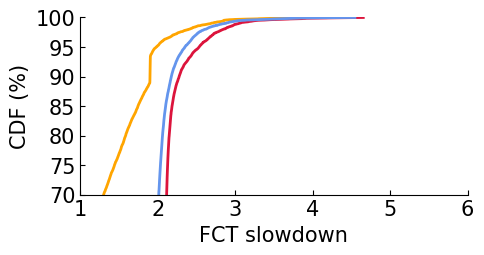

In [11]:
# Section 5.4, figure 8
size_bins = [0, 1 * 1024, 200 * 1024, 1024 * 1024, np.inf]  # Sizes in bytes
size_bin_labels = ['<=1KB', '1KB-200KB','200KB-1MB', '1MB']
legend_list=['UNISON','flowSim',sys_name]
model_instance_list=['flowsim',"m4"]
n_methods = len(legend_list)
empirical_str = f"eval_large"

fig_index=0
for scenario_idx in [0]:
    
    sizes=np.load(f'./parsimon-eval/expts/fig_7/data/{scenario_idx}/ns3/fsize.npy')
    error_list=[]
    error_size_list=[]
    for model_idx,model_instance in enumerate(model_instance_list):
        data_FLS = np.load(f'./results/{model_instance}_{empirical_str}.npz')
        sldn = data_FLS['sldn']
        predicted_sldns = sldn[scenario_idx, :, 0]
        actual_sldns = sldn[scenario_idx,:, 1]
        predicted_sldns=predicted_sldns[actual_sldns>0]
        actual_sldns=actual_sldns[actual_sldns>0]
        assert predicted_sldns.size == actual_sldns.size==sizes.size
        
        if model_idx==0:
            error_list.extend([actual_sldns,predicted_sldns])
            error_size_list.extend([sizes,sizes])
        else:
            error_list.append(predicted_sldns)
            error_size_list.append(sizes)

    # Initialize a dictionary to store errors per size bucket for each model instance
    error_bins = {legend: {label: np.array([]) for label in size_bin_labels} for legend in legend_list}

    # Process the data for each model instance
    for mi in range(n_methods):
        legend = legend_list[mi]
        errors = error_list[mi]  # Shape: (n_scenarios, n_flows)
        sizes = error_size_list[mi]  # Shape: (n_scenarios, n_flows)

        # Flatten the arrays
        errors_flat = errors.flatten()
        sizes_flat = sizes.flatten()

        # Assign flows to size buckets
        size_indices = np.digitize(sizes_flat, size_bins)

        # Collect errors for each size bucket
        for b in range(1, len(size_bins)):
            bin_mask = size_indices == b
            bin_errors = errors_flat[bin_mask]
            error_bins[legend][size_bin_labels[b - 1]] = np.concatenate((error_bins[legend][size_bin_labels[b - 1]], bin_errors))

    # Plot the CDF of errors for each size bucket
    for idx, size_bin_label in enumerate(size_bin_labels):
        plot_data=[]
        for mi, legend in enumerate(legend_list):
            bin_errors = error_bins[legend][size_bin_label]
            plot_data.append(bin_errors)
        plot_cdf(plot_data,f'./figs/eva_large_scale_cdf_{idx}.pdf',legend_list if idx==0 else [],'FCT slowdown',legend_font=20,group_size=3,loc=4,rotate_xaxis=False,ylim_low=70,log_switch=False,xlim_bottom=1, fig_idx=fig_index,xlim=6)
        fig_index+=1

-----------------
flowsim # flows: (50000,)
m4 # flows: (50000,)
mean error for ['flowsim', 'm4']:[22.44376998824202, 4.418006284750322]
p90 error for ['flowsim', 'm4']: [53.58450545152686, 10.52377348099926]
-----------------
flowsim # flows: (50000,)
m4 # flows: (50000,)
mean error for ['flowsim', 'm4']:[9.341467860304254, 3.9927504644095566]
p90 error for ['flowsim', 'm4']: [39.87038983741876, 11.09251281345609]
-----------------
flowsim # flows: (50000,)
m4 # flows: (50000,)
mean error for ['flowsim', 'm4']:[12.44603325438384, 2.652951569445404]
p90 error for ['flowsim', 'm4']: [48.77471225952104, 7.3891160079291485]


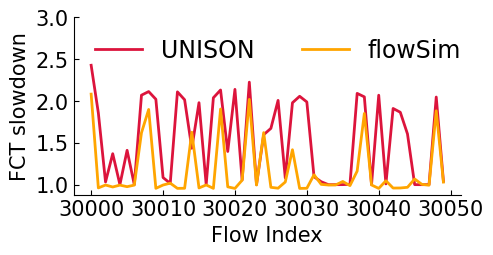

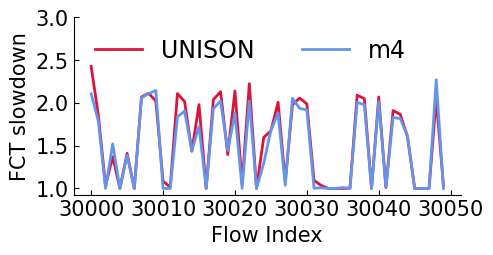

In [12]:
# Section 5.4, figure 9, table 5, 6
empirical_str = "eval_large"
model_instance_list=['flowsim',"m4"]
legend_list=['flowSim',sys_name]

for scenario_idx in range(3):
    error_list=[]
    sldn_list=[]
    fct_list=[]
    print(f"-----------------")
    for model_instance in model_instance_list:
        data_m4 = np.load(f'./results/{model_instance}_{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[scenario_idx, :, 0].squeeze()
        actual_sldns = sldn[scenario_idx,:, 1].squeeze()
        predicted_sldns=predicted_sldns[actual_sldns>0]
        actual_sldns=actual_sldns[actual_sldns>0]
        print(f"{model_instance} # flows: {predicted_sldns.shape}")
        
        fct=data_m4['fct']
        predicted_fcts = fct[scenario_idx, :, 0].squeeze()
        actual_fcts = fct[scenario_idx,:, 1].squeeze()
        predicted_fcts=predicted_fcts[actual_fcts>0]
        actual_fcts=actual_fcts[actual_fcts>0]
        
        # calculate the relative error
        relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
        sldn_list.append([actual_sldns,predicted_sldns])
        fct_list.append([actual_fcts,predicted_fcts])
        error_list.append(relative_error_sldn)
        
    error_list=np.array(error_list)
    sldn_list=np.array(sldn_list)
    fct_list=np.array(fct_list)
    print(f"mean error for {model_instance_list}:{[np.mean(x) for x in error_list]}")
    print(f"p90 error for {model_instance_list}: {[np.percentile(x,90) for x in error_list]}")
    
    if scenario_idx==0:  
        fig_idx=0
        data_x=np.arange(30000, 30050)
        linelabels = [["UNISON","flowSim"],["UNISON",sys_name]]
        format_idx=[[0,1],[0,2]]
        for i, (actual, predicted) in enumerate(sldn_list):
            plot_data=[(data_x,actual[data_x]),(data_x,predicted[data_x])]
            plot_lines(
                plot_data,
                f'./figs/eva_large_scale_line_sldn_{i}.pdf',
                linelabels[i],
                x_label="Flow Index",
                y_label="FCT slowdown",
                title=None,
                ylim=3,
                format_idx=format_idx[i],
                legend_cols=2,
                legend_font=17,
                fig_idx=fig_idx,
            )
            fig_idx+=1

mean error ['flowsim', 'm3', 'm4']: [17.135036655379754, 18.833820963031805, 7.313676928788696]
p90 error ['flowsim', 'm3', 'm4']: [50.600817737600124, 46.88180716307853, 18.685288650884434]
p99 slowdown error ['flowsim', 'm3', 'm4']: [23.316546687199242, 9.640100115006522, 11.27162157714883]


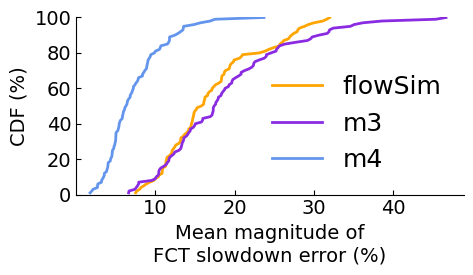

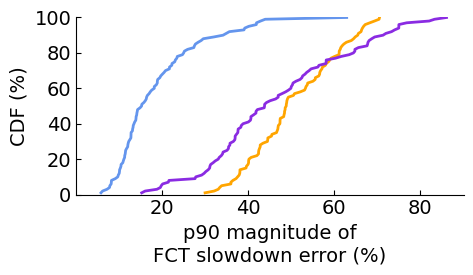

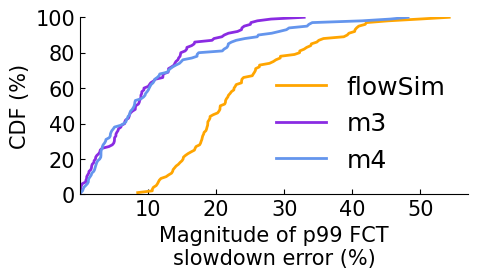

In [13]:
# Section 5.5, figure 10
n_scenario=100
empirical_str = "eval_test"
legend_list=['flowSim','m3',sys_name]
model_instance_list=['flowsim','m3','m4']
                     
n_methods = len(legend_list)
config_file=f'./parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

config_list=[]
for i in range(n_scenario):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
config_list=np.array(config_list)

error_list=[]
error_list_p90=[]
# error_list_rms=[]
error_list_p99=[]
for model_instance in model_instance_list:
    if model_instance == 'm3':
        data_m3 = np.load('./results/m3_eval_test.npz')
        m3_mean_errors = data_m3['m3_mean_errors']
        m3_p90_errors = data_m3['m3_p90_errors']
        m3_p99_errors = abs(data_m3['m3_p99_errors'] * 100)  # Convert to percentage
        
        error_list.append(m3_mean_errors)
        error_list_p90.append(m3_p90_errors) 
        error_list_p99.append(m3_p99_errors)
        
    else:
        # Original processing for flowsim and m4
        data_m4 = np.load(f'./results/{model_instance}_{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[:, :, 0]
        actual_sldns = sldn[:,:, 1]
        
        predicted_sldns[predicted_sldns==0]=1
        actual_sldns[actual_sldns==0]=1
        
        # calculate the relative error
        relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
        relative_error_sldn_mean=np.mean(relative_error_sldn,axis=1)
        relative_error_sldn_p90=np.percentile(relative_error_sldn,90,axis=1)
        
        sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
        sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
        
        error_list.append(relative_error_sldn_mean)
        error_list_p90.append(relative_error_sldn_p90)
        error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
error_list=np.array(error_list)
error_list_p90=np.array(error_list_p90)
error_list_p99=np.array(error_list_p99)

print(f"mean error {model_instance_list}: {[np.mean(x) for x in error_list]}")
print(f"p90 error {model_instance_list}: {[np.mean(x) for x in error_list_p90]}")
print(f"p99 slowdown error {model_instance_list}: {[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_cdf_mean.pdf",
    legend_list,
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=14,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=3,
    colors=["orange", "blueviolet","cornflowerblue"],
    fig_idx=fig_idx,
    # fig_size=(3, 2.3),
)
fig_idx+=1

plot_cdf(
    error_list_p90,
    f"./figs/eva_cdf_p90.pdf",
    [],
    x_label="p90 magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=14,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=3,
    colors=["orange", "blueviolet","cornflowerblue"],
    fig_idx=fig_idx,
    # fig_size=(3, 2.3),
)
fig_idx+=1

plot_cdf(
    error_list_p99,
    f"./figs/eva_cdf_tailsldn.pdf",
    legend_list,
    x_label="Magnitude of p99 FCT\nslowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange", "blueviolet","cornflowerblue"],
    fig_idx=fig_idx,
)
fig_idx+=1

flowsim [# scenarios, # flows]: (100, 20000)
m4 [# scenarios, # flows]: (100, 20000)


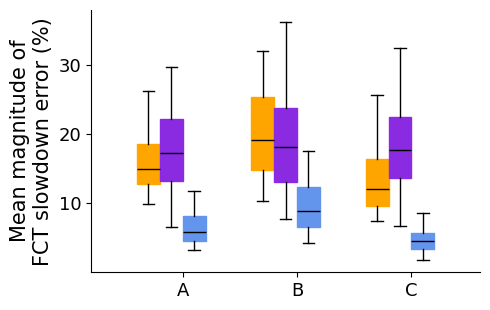

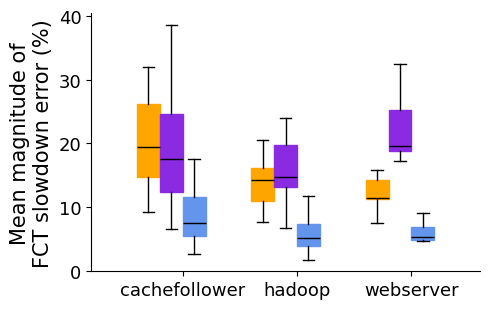

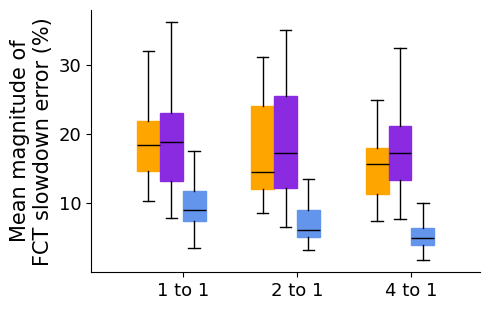

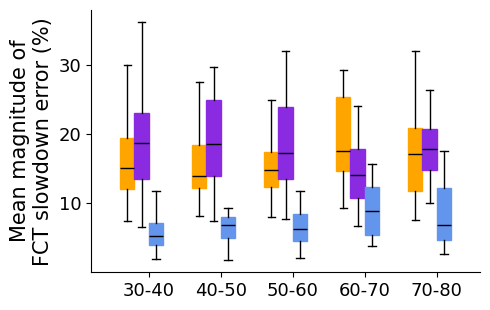

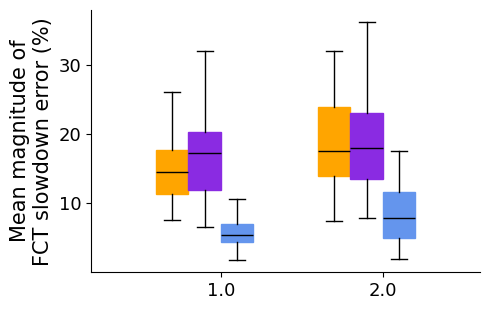

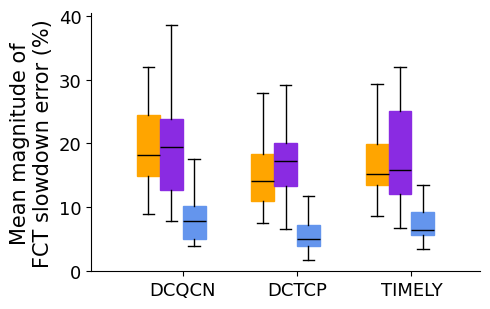

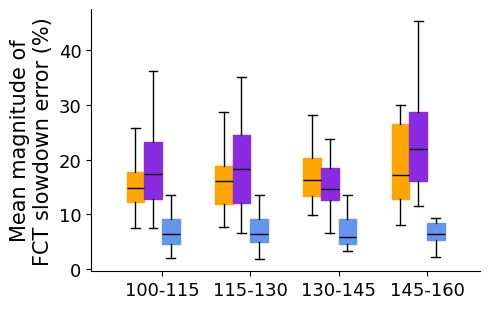

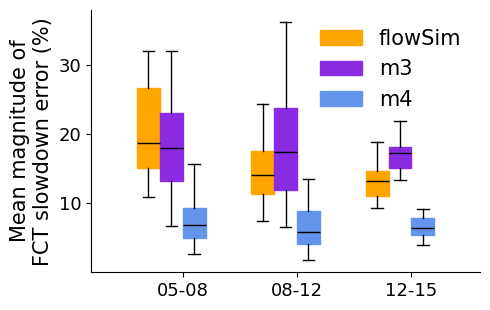

In [14]:
# Section 5.5, figure 11
n_scenario=100
empirical_str = "eval_test"
legend_list=['flowSim','m3',sys_name]
model_instance_list=['flowsim','m3','m4']
                     
n_methods = len(legend_list)
config_file=f'./parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

config_list=[]
for i in range(n_scenario):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    if model_instance == 'm3':
        data_m3 = np.load('./results/m3_eval_test.npz')
        m3_mean_errors = data_m3['m3_mean_errors']
        m3_p90_errors = data_m3['m3_p90_errors']
        m3_p99_errors = abs(data_m3['m3_p99_errors'] * 100)  # Convert to percentage
        
        error_list.append(m3_mean_errors)
        error_list_p99.append(m3_p99_errors)
        
    else:
        data_m4 = np.load(f'./results/{model_instance}_{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[:, :, 0]
        actual_sldns = sldn[:,:, 1]
        print(f"{model_instance} [# scenarios, # flows]: {predicted_sldns.shape}")
        
        predicted_sldns[predicted_sldns==0]=1
        actual_sldns[actual_sldns==0]=1
        # calculate the relative error
        relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
        sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
        sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
        
        error_list.append(relative_error_sldn)
        error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

fig_idx=0

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3,0.4, 0.5, 0.6, 0.70,0.80]
labels = ['30-40', '40-50', '50-60', '60-70','70-80']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bfsz_values=bfsz_values*10
bins = [100,115,130,145,160]
labels = ['100-115', '115-130', '130-145', '145-160']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [5000,8000,12000,15000]
labels = ['05-08', '08-12','12-15']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)

# Generate plots for each configuration attribute
config_attributes = ["Traffic matrix", "Flow size distribution", "Oversubscription", "Max load (%)", "Burstiness (log-normal's $\sigma$)", "Congestion control algorithm", "Buffer size (KB)", "Init. window size (KB)"]
error_list=error_list.T
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list, legend_list if i==7 else None,n_methods=len(legend_list),config_list=config_list, config_index=i, config_name=config_name,fig_idx=fig_idx,loc=1,file_name=f"figs/eva_box_{i}.pdf",y_label="Mean magnitude of\nFCT slowdown error (%)",legend_font=15,colors=["orange", "blueviolet", "cornflowerblue"])
    fig_idx+=1

mean error ['m4', 'm4_nosize', 'm4_noqueue']: [7.313676928788696, 11.047066007712047, 10.044714035686404]
p90 error ['m4', 'm4_nosize', 'm4_noqueue']: [18.685288650884434, 28.46071304720142, 24.977523637396366]
p99 error ['m4', 'm4_nosize', 'm4_noqueue']: [11.27162157714883, 18.472758112524716, 16.198954787094927]


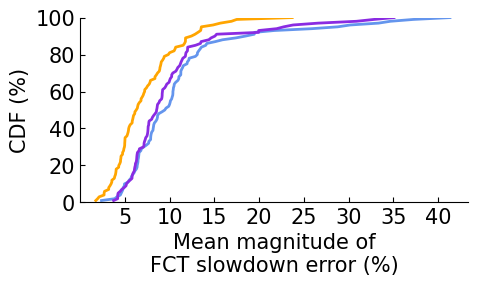

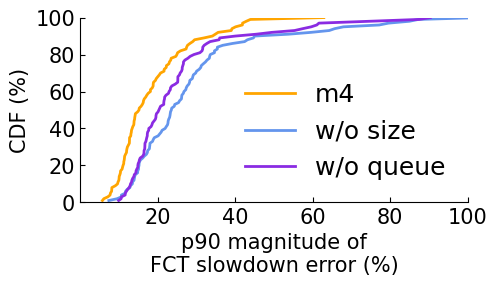

In [15]:
# Section 5.6, figure 12, table 7
n_scenario=100
empirical_str = "eval_test"
legend_list=[sys_name,'w/o size','w/o queue']
model_instance_list=['m4','m4_nosize','m4_noqueue']
                     
n_methods = len(legend_list)
config_file=f'./parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

config_list=[]
for i in range(n_scenario):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
config_list=np.array(config_list)

error_list=[]
error_list_p90=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./results/{model_instance}_{empirical_str}.npz')
    sldn = data_m4['sldn']
    predicted_sldns = sldn[:, :, 0]
    actual_sldns = sldn[:,:, 1]
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    
    # calculate the relative error
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    relative_error_sldn_mean=np.mean(relative_error_sldn,axis=1)
    relative_error_sldn_p90=np.percentile(relative_error_sldn,90,axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn_mean)
    error_list_p90.append(relative_error_sldn_p90)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
error_list=np.array(error_list)
error_list_p90=np.array(error_list_p90)
error_list_p99=np.array(error_list_p99)

print(f"mean error {model_instance_list}: {[np.mean(x) for x in error_list]}")
print(f"p90 error {model_instance_list}: {[np.mean(x) for x in error_list_p90]}")
print(f"p99 error {model_instance_list}: {[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_ablation_mean.pdf",
    [],
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=15,
    loc=4,
    enable_abs=True,
    group_size=6,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato',
    'magenta'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1

plot_cdf(
    error_list_p90,
    f"./figs/eva_ablation_p90.pdf",
    legend_list,
    x_label="p90 magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    xlim=100,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=6,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato',
    'magenta'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)

mean error ['m4', 'm4_noseq', 'm4_nognn', 'm4_gnn2', 'm4_gnn4']: [7.313676928788696, 10.826050981651179, 18.190242798425725, 11.565861072574833, 7.446938623385488]
p90 error ['m4', 'm4_noseq', 'm4_nognn', 'm4_gnn2', 'm4_gnn4']: [18.685288650884434, 26.10616274561352, 46.750925935165206, 27.272519624601568, 19.85157174754824]
p99 error ['m4', 'm4_noseq', 'm4_nognn', 'm4_gnn2', 'm4_gnn4']: [11.27162157714883, 29.821576245628812, 47.220846237867505, 25.03808034005185, 13.44965896595164]


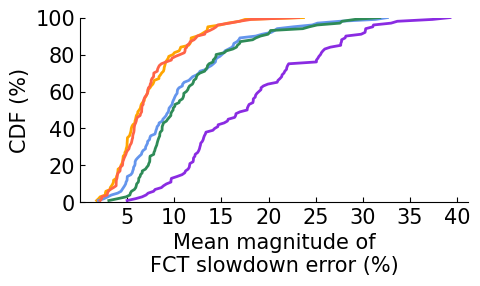

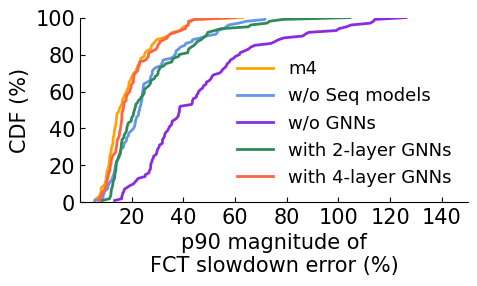

In [16]:
# Section 5.6, figure 12, table 7
n_scenario=100
empirical_str = "eval_test"
legend_list=[sys_name,'w/o Seq models','w/o GNNs','with 2-layer GNNs','with 4-layer GNNs']
model_instance_list=['m4','m4_noseq','m4_nognn','m4_gnn2','m4_gnn4']
                     
n_methods = len(legend_list)
config_file=f'./parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

config_list=[]
for i in range(n_scenario):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
config_list=np.array(config_list)

error_list=[]
error_list_p90=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./results/{model_instance}_{empirical_str}.npz')
    sldn = data_m4['sldn']
    predicted_sldns = sldn[:, :, 0]
    actual_sldns = sldn[:,:, 1]
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    relative_error_sldn_mean=np.mean(relative_error_sldn,axis=1)
    relative_error_sldn_p90=np.percentile(relative_error_sldn,90,axis=1)
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn_mean)
    error_list_p90.append(relative_error_sldn_p90)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
error_list=np.array(error_list)
error_list_p90=np.array(error_list_p90)
error_list_p99=np.array(error_list_p99)

print(f"mean error {model_instance_list}: {[np.mean(x) for x in error_list]}")
print(f"p90 error {model_instance_list}: {[np.mean(x) for x in error_list_p90]}")
print(f"p99 error {model_instance_list}: {[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_ablation_mean_model.pdf",
    [],
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=6,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato',
    'magenta'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1

plot_cdf(
    error_list_p90,
    f"./figs/eva_ablation_p90_model.pdf",
    legend_list,
    x_label="p90 magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=13,
    loc=4,
    enable_abs=True,
    group_size=6,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato',
    'magenta'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1


S=0, N=1, #flows: 20000, end_time: 380547060.0
S=0, N=1, #flows: 19716, end_time: 1997734684.0
S=0, N=1, #flows: 20000, end_time: 1079987365.0
S=0, N=1, #flows: 20000, end_time: 129346528.0
S=0, N=1, #flows: 20000, end_time: 745600350.0
S=0, N=1, #flows: 20000, end_time: 655191531.0
S=0, N=1, #flows: 19992, end_time: 106221925.0
S=0, N=1, #flows: 19979, end_time: 618436039.0
S=0, N=1, #flows: 20000, end_time: 560738719.0
S=0, N=1, #flows: 19959, end_time: 139591924.0
S=0, N=1, #flows: 19926, end_time: 618030116.0
mean error in application, m4: 0.11538737624700911, flowsim: 0.20047561649502008
p90 error in application, m4: 0.2363564102143571, flowsim: 0.32734729163478193
gt_result_list: (105,)



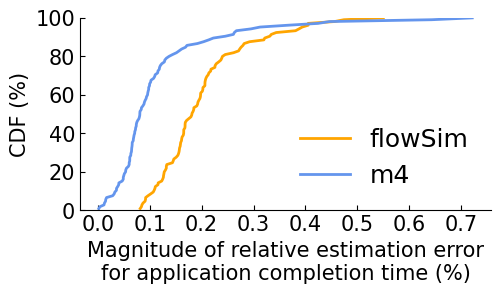

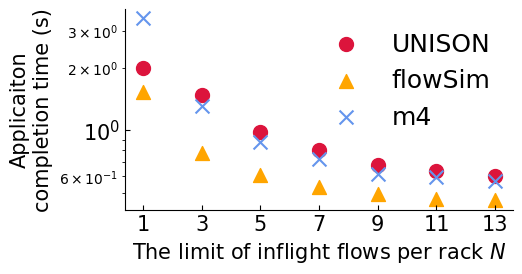

In [17]:
# Appendix 1, figure 14
n_scenario=105
empirical_str = "eval_app"
legend_list=['UNISON',sys_name, 'flowsim']
N_list = [1, 3, 5, 7, 9, 11, 13]
root_dir=f"./parsimon-eval/expts/fig_8/{empirical_str}"

config_file=f'./parsimon-eval/expts/fig_8/spec/{empirical_str}.mix.json'
configs=json.load(open(config_file))

gt_result_list=[]
m4_result_list = []
flowsim_result_list = []
m4_error = []
flowsim_error = []
for i in range(n_scenario):
    if os.path.exists(f'{root_dir}/{i}/ns3/fct_topology_flows.npy'):
        file_path=f"{root_dir}/{i}/ns3/fct_topology_flows.txt"
        m4_path = f"{root_dir}/{i}/ns3/m4_fct.npy"
        with open(file_path, "r") as file:
            reader = csv.reader(file, delimiter=" ")
            fats, fcts = [], []
            for row in reader:
                # Remove empty strings caused by multiple spaces
                cleaned_row = [item for item in row if item.strip() != ""]
                # Extract the last third and second columns
                if len(cleaned_row) >= 3:
                    fats.append(cleaned_row[-3])
                    fcts.append(cleaned_row[-2])
            
            # Convert to numpy arrays and calculate gt_result
            fats = np.array(fats).astype(np.int64)
            fcts = np.array(fcts).astype(np.int64)
            end_time = np.max(fats + fcts)-1e9
            if i%10==0:
                print(f"S=0, N={N_list[i%10]}, #flows: {len(fats)}, end_time: {end_time}")
            # gt_result = len(fats) / (end_time / 1e9)
            gt_result = end_time / 1e9
            gt_result_list.append(gt_result)

            fids = np.load(f"{root_dir}/{i}/ns3/fid_topology_flows.npy")

            m4_fats = np.load(f"{root_dir}/{i}/ns3/m4_release_times.npy")
            m4_fcts = np.load(f"{root_dir}/{i}/ns3/m4_fct.npy")
            m4_end_time = np.max(m4_fcts + m4_fats) - 1e9
            # m4_result = len(m4_fats) / (m4_end_time / 1e9)
            m4_result = m4_end_time/1e9
            m4_result_list.append(m4_result)

            m4_error.append(abs(m4_result - gt_result) / gt_result)

            flowsim_fats = np.load(f"{root_dir}/{i}/ns3/flowsim_release_times.npy")
            flowsim_fcts = np.load(f"{root_dir}/{i}/ns3/app_flowsim_fct.npy")
            flowsim_end_time = np.max(flowsim_fcts + flowsim_fats) - 1e9
            flowsim_result = flowsim_end_time /1e9
            # flowsim_result = len(flowsim_fats) / (flowsim_end_time / 1e9)
            flowsim_result_list.append(flowsim_result)

            flowsim_error.append(abs(flowsim_result - gt_result) / gt_result)
        
            
gt_result_list=np.array(gt_result_list)
m4_result_list = np.array(m4_result_list)
flowsim_result_list = np.array(flowsim_result_list)

m4_error = np.array(m4_error)
flowsim_error = np.array(flowsim_error)
print("mean error in application, m4: {}, flowsim: {}".format(np.mean(m4_error), np.mean(flowsim_error)))
print("p90 error in application, m4: {}, flowsim: {}".format(np.percentile(m4_error,90), np.percentile(flowsim_error,90)))
print(f"gt_result_list: {gt_result_list.shape}")
fig_idx=0
plot_cdf(
    [flowsim_error,m4_error],
    f"./figs/eva_app_cdf.pdf",
    # None,
    ["flowSim",sys_name],
    x_label="Magnitude of relative estimation error\nfor application completion time (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    # xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue", "purple"],
    fig_idx=fig_idx,
    fig_size=(5.3,2.5)
)
fig_idx+=1

# Group scenarios into configurations
group_size = len(N_list)
num_configs = len(gt_result_list) // group_size
config_labels = [f"$S$={n}" for n in range(num_configs)]

print(f"")
raw_data=[]
m4_raw_data = []
flowsim_raw_data = []
for i in range(num_configs):
    tmp=[]
    m4_tmp=[]
    flowsim_tmp=[]
    for j in range(group_size):
        tmp.append(gt_result_list[j*num_configs+i])
        m4_tmp.append(m4_result_list[j*num_configs+i])
        flowsim_tmp.append(flowsim_result_list[j*num_configs+i])
    tmp=np.array(tmp)
    m4_tmp = np.array(m4_tmp)
    flowsim_tmp = np.array(flowsim_tmp)
    raw_data.append((N_list,tmp))
    m4_raw_data.append((N_list, m4_tmp))
    flowsim_raw_data.append((N_list, flowsim_tmp))

# Plot the data
for i in [9]:
    plot_scatter(
        [raw_data[i], flowsim_raw_data[i],m4_raw_data[i]],
        file_name=None,  # Don't save yet, we need to fix x-axis first
        linelabels=["UNISON", "flowSim",sys_name],
        x_label="The limit of inflight flows per rack $N$",
        y_label="Applicaiton\ncompletion time (s)",
        log_switch=True,
        rotate_xaxis=False,
        ylim=None,
        # xlim=14,
        # xlim_left=1,
        fontsize=15,
        legend_font=18,
        loc=1,
        legend_cols=1,
        # title="Throughput Across Scenarios",
        fig_size=(5, 2.6),
        colors=["crimson",
            "orange",
            "cornflowerblue"],  # Example colors
        fig_idx=fig_idx,
        marker_size=100
    )
    # Fix x-axis to show correct odd numbers instead of even numbers
    plt.xticks(N_list, N_list)
    plt.savefig('./figs/eva_app_scatter.pdf', bbox_inches='tight', pad_inches=0)
    fig_idx+=1

mean time for UNISON: 786.7508, m4: 54.858026249408724, ns3: 1982.2583000000002
mean speedup (m4 vs unison): 14.360598167737958, min speedup: 1.9805035784145837, max speedup: 29.00139371626606
mean speedup (unison vs ns3): 3.3044488285568496, min speedup: 1.320282130124465, max speedup: 14.628383544884539


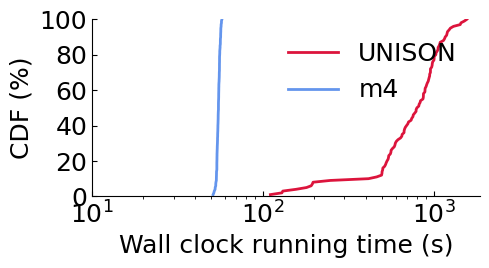

In [18]:
# Section 5.5, figure 10
n_scenario = 100
empirical_str = "eval_test"
legend_list = ['UNISON', sys_name,'ns-3']
config_file = f'./parsimon-eval/expts/fig_8/spec/{empirical_str}.mix.json'

# Load configurations
configs = json.load(open(config_file))

# Data containers
simulation_times_unison = []
config_list = []

for i in range(n_scenario):
    base_dir = f'./parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3'
    log_file = os.path.join(base_dir, 'log_sim.txt')
    with open(log_file, 'r') as file:
        current_block = []
        for line in file:
            current_block.append(line)
            if "Total run time" in line:
                block_text = ''.join(current_block)
                match = re.search(r"Simulation time:\s+([\d.]+)s", block_text)
                if match:
                    simulation_times_unison.append(float(match.group(1)))
                current_block = []
                    
    config = configs[i]
    spatial = config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist = config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster_parts = config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster = f"{cluster_parts[1]} to {cluster_parts[3]}"
    max_load = float(config['max_load'])
    lognorm_sigma = float(config['lognorm_sigma'])
    cc = config['cc'].upper()
    bfsz = float(config['bfsz'])
    fwin = float(config['window'])

    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma, cc, bfsz, fwin])
config_list = np.array(config_list)
simulation_times_unison=np.array(simulation_times_unison)

simulation_times_m4=np.load(f'./results/m4_{empirical_str}_time.npy')

# Data containers
simulation_times_ns3 = []
for i in range(n_scenario):
    base_dir = f'./parsimon-eval/expts/fig_8/{empirical_str}_ns3/{i}/ns3'
    log_file = os.path.join(base_dir, 'log_sim.txt')
    with open(log_file, 'r') as file:
        current_block = []
        for line in file:
            current_block.append(line)
            if "Total run time" in line:
                block_text = ''.join(current_block)
                match = re.search(r"Simulation time:\s+([\d.]+)s", block_text)
                if match:
                    simulation_times_ns3.append(float(match.group(1)))
                current_block = []
simulation_times_ns3 = np.array(simulation_times_ns3)

print(f"mean time for UNISON: {np.mean(simulation_times_unison)}, m4: {np.mean(simulation_times_m4)}, ns3: {np.mean(simulation_times_ns3)}")

speedup = simulation_times_unison/simulation_times_m4
print(f"mean speedup (m4 vs unison): {np.mean(speedup)}, min speedup: {np.min(speedup)}, max speedup: {np.max(speedup)}")
speedup_unison = simulation_times_ns3/simulation_times_unison
print(f"mean speedup (unison vs ns3): {np.mean(speedup_unison)}, min speedup: {np.min(speedup_unison)}, max speedup: {np.max(speedup_unison)}")


# plot_data=np.array([simulation_times_unison,simulation_times_m4,simulation_times_ns3])
plot_data=np.array([simulation_times_unison,simulation_times_m4])
plot_cdf(
    plot_data,
    f"./figs/eva_cdf_time.pdf",
    legend_list,
    x_label="Wall clock running time (s)",
    log_switch=True,
    rotate_xaxis=False,
    # ylim_low=90,
    xlim_bottom=10,
    fontsize=18,
    legend_font=18,
    loc=1,
    enable_abs=True,
    group_size=5,
    colors=["crimson",
    "cornflowerblue","orange"],
    fig_idx=0,
    # fig_size=(3, 2.3),
)